In [1]:
# call __init_ to set notebook seed
import set_notebook_env
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import statsmodels.formula.api as smf
from scipy.stats import mannwhitneyu
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from utils.modeling_helpers import ModelHelper
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA

from collections import defaultdict
import numpy as np

import set_notebook_env
loader, plot_utils = set_notebook_env.set_env(
    data_dir="../data/", 
    min_ratings=0, 
    max_ratings=None,
    drop_inconsistent_gender = True
)

SEED = np.random.get_state()[1][0]

loader.initial_setup()
NUM_COLS = loader.num_cols + ['gender_code']

prepared_df = loader.prepared_df
prepared_df = loader.add_gender_code(loader.prepared_df)

MODEL_HELPER = ModelHelper(df=prepared_df, random_seed=SEED)

prepared_df.columns


Using seed: 18787288


Index(['avg_rating', 'avg_difficulty', 'num_ratings', 'pepper',
       'would_take_again_prop', 'num_online_ratings', 'male', 'female',
       'tough_grader', 'good_feedback', 'respected', 'lots_to_read',
       'participation_matters', 'no_skip', 'lots_of_hw', 'inspirational',
       'pop_quizzes', 'accessible', 'papers', 'clear_grading', 'hilarious',
       'test_heavy', 'few_things', 'amazing_lectures', 'caring',
       'extra_credit', 'group_projects', 'lecture_heavy', 'major',
       'university', 'state', 'gender_code'],
      dtype='object')

In [2]:

for col in NUM_COLS:
    print(f"{col} : {prepared_df[col].isna().sum()}")
    
tag_cols = [
    c for c in NUM_COLS
    if not any(g in c.lower() for g in ["would_take_again_prop", "female", "male"])
]


d = prepared_df[tag_cols]



avg_rating : 0
avg_difficulty : 0
num_ratings : 0
pepper : 0
would_take_again_prop : 43239
num_online_ratings : 0
male : 0
female : 0
gender_code : 0


Rows with ≥1 NA in tag cols: 0 (0.00%)


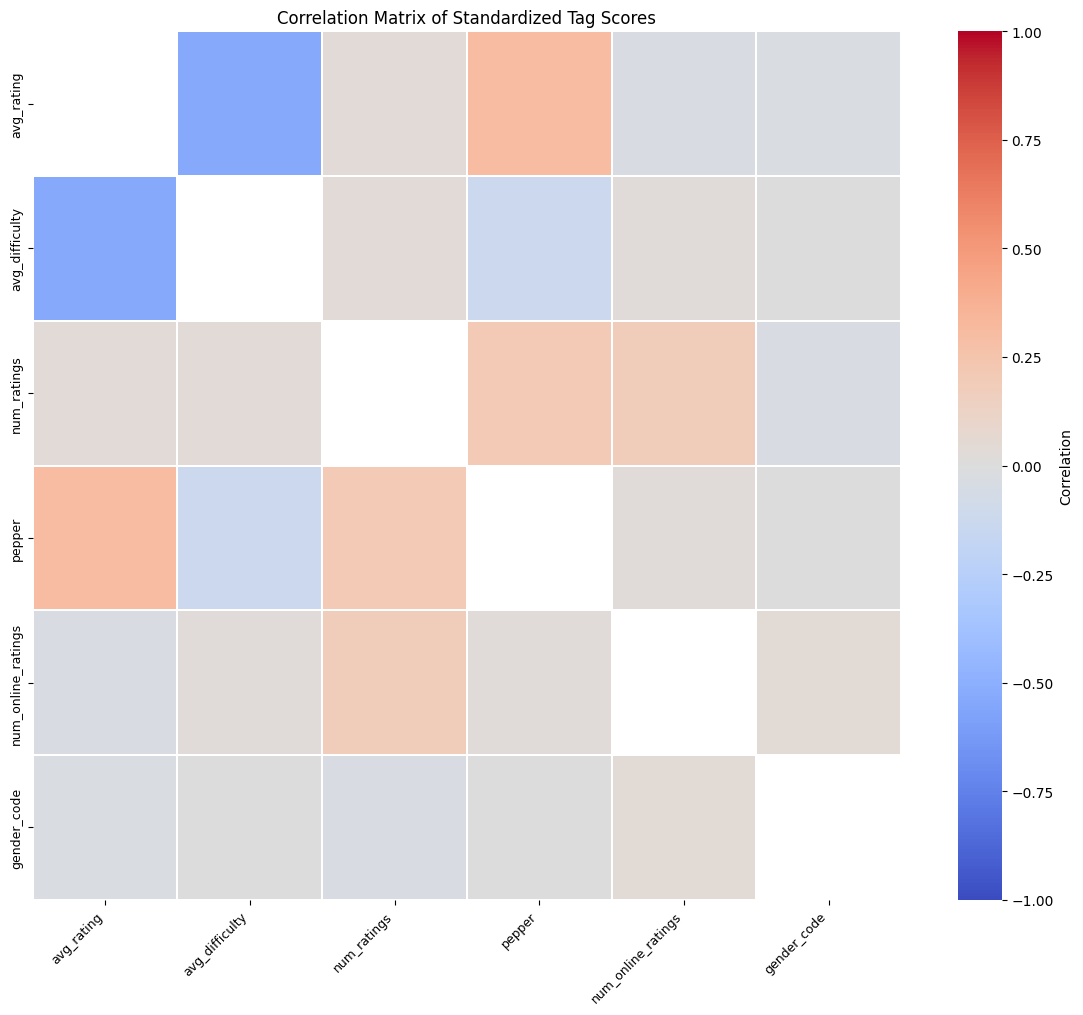

In [ ]:

n_before = len(d)
na_rows = d.isna().any(axis=1).sum()
print(f"Rows with ≥1 NA in tag cols: {na_rows} ({na_rows/n_before:.2%})")

scaler = StandardScaler()
d_scaled = scaler.fit_transform(d)

d_scaled_df = pd.DataFrame(d_scaled, columns=tag_cols, index=prepared_df.index)

d = prepared_df[tag_cols]

d_scaled = scaler.fit_transform(d)

d_scaled_df = pd.DataFrame(
    d_scaled,
    columns=tag_cols,
    index=prepared_df.index
)

corr_matrix = d_scaled_df.corr()
diag_mask = np.eye(len(corr_matrix), dtype=bool)

plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix,
    mask=diag_mask,
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
    center=0,
    square=True,
    linewidths=0.3,
    cbar_kws={"label": "Correlation"}
)

plt.xticks(rotation=45, ha="right", fontsize=9)
plt.yticks(fontsize=9)
plt.title("Correlation Matrix of Standardized Tag Scores")
plt.tight_layout()
plt.show()


In [12]:
pca = PCA()

Y = d_scaled_df['avg_rating']
X = d_scaled_df.drop(columns=['avg_rating'])

X_pca = pca.fit_transform(X)

X_pca_df = pd.DataFrame(
    X_pca,
    index=d_scaled_df.index,
    columns=[f"PC{i+1}" for i in range(X_pca.shape[1])]
)

df_pca = pd.concat([Y, X_pca_df], axis=1)
df_pca.head()

,avg_rating,PC1,PC2,PC3,PC4,PC5
0,-0.579211,-0.600483,0.065066,0.988488,0.263669,0.175499
1,-0.310164,3.834667,3.831461,0.301186,3.864582,-0.701367
2,-0.758575,-0.640892,-1.185453,-1.431590,0.905965,0.795152
3,0.586659,-0.887244,0.288475,-0.956989,-0.216577,0.201974
4,-0.758575,-0.887244,0.288475,-0.956989,-0.216577,0.201974


In [16]:
loadings = pd.DataFrame(
    pca.components_.T,
    index=X.columns,   # original feature names
    columns=[f"PC{i+1}" for i in range(X_pca.shape[1])]
)

loadings.abs().sort_values('PC1', ascending=False).head(10)


,PC1,PC2,PC3,PC4,PC5
num_ratings,0.673934,0.177897,0.171331,0.195078,0.668398
pepper,0.572026,0.427906,0.041551,0.403725,0.570055
num_online_ratings,0.451005,0.480111,0.174735,0.642592,0.350187
avg_difficulty,0.122107,0.730567,0.235240,0.556399,0.294014
gender_code,0.016849,0.144966,0.939707,0.276489,0.138586


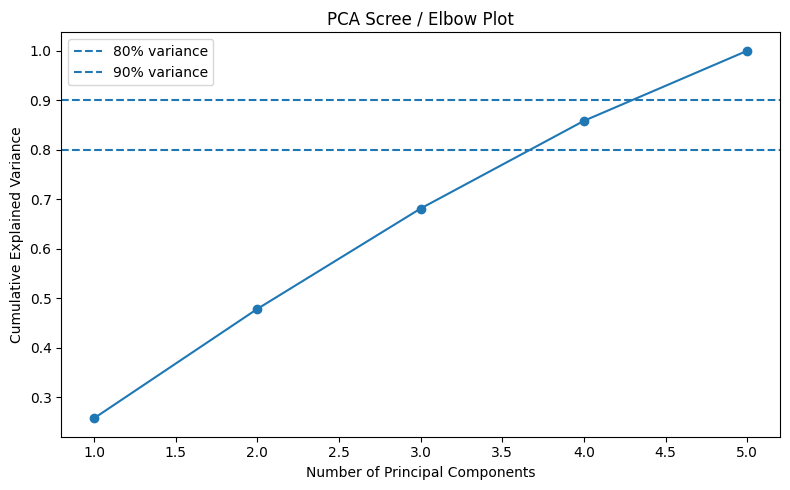

In [ ]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

pca = PCA()
X_pca_full = pca.fit_transform(X)  # X = scaled predictors, no avg_rating

explained_var = pca.explained_variance_ratio_
cum_explained = np.cumsum(explained_var)

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_var) + 1), cum_explained, marker='o')
plt.axhline(0.8, linestyle='--', label='80% variance')
plt.axhline(0.9, linestyle='--', label='90% variance')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Scree / Elbow Plot")
plt.legend()
plt.tight_layout()
plt.show()

# While PCA reduced multicollinearity, variance was distributed across several components, 
# indicating that multiple distinct dimensions contribute meaningfully to the data.

In [21]:
k_folds = MODEL_HELPER.kfold_split()

model=LinearRegression()

res = MODEL_HELPER.cross_val_score(
    model,
    X=X,
    y=Y,
    kfolds=k_folds,
    scoring_methods=["rmse", "r2", "mae"]
)

In [26]:
tag_cols


['avg_rating',
 'avg_difficulty',
 'num_ratings',
 'pepper',
 'num_online_ratings',
 'gender_code']

In [29]:
top_scores = {}

for i, f in enumerate(res["fitted_models"]):
    coefs = pd.Series(
        f.coef_,  # or pipeline.named_steps["lr"].coef_
        index=X.columns
    ).sort_values(key=np.abs, ascending=False)

    feat = coefs.head(5)
    top_scores[i] = feat

top_scores

{0: avg_difficulty       -0.501576
 pepper                0.244891
 gender_code          -0.030626
 num_online_ratings   -0.021413
 num_ratings           0.006376
 dtype: float64,
 1: avg_difficulty       -0.500711
 pepper                0.244827
 num_online_ratings   -0.027889
 gender_code          -0.024774
 num_ratings           0.006004
 dtype: float64,
 2: avg_difficulty       -0.503618
 pepper                0.244884
 gender_code          -0.027773
 num_online_ratings   -0.024826
 num_ratings           0.008176
 dtype: float64,
 3: avg_difficulty       -0.503708
 pepper                0.243970
 gender_code          -0.026909
 num_online_ratings   -0.024475
 num_ratings           0.006892
 dtype: float64,
 4: avg_difficulty       -0.504425
 pepper                0.245276
 gender_code          -0.027811
 num_online_ratings   -0.025142
 num_ratings           0.007299
 dtype: float64}

In [30]:
coef_df = []

for fold, series in top_scores.items():
    tmp = series.reset_index()
    tmp.columns = ["feature", "coef"]
    tmp["abs_coef"] = tmp["coef"].abs()
    tmp["fold"] = fold
    coef_df.append(tmp)

coef_df = pd.concat(coef_df, ignore_index=True)
coef_df

summary = (
    coef_df
    .groupby("feature")
    .agg(
        mean_abs_coef=("abs_coef", "mean"),
        times_in_top5=("feature", "count")
    )
    .sort_values("mean_abs_coef", ascending=False)
)

summary

,mean_abs_coef,times_in_top5
feature,,
avg_difficulty,0.502808,5
pepper,0.244770,5
gender_code,0.027579,5
num_online_ratings,0.024749,5
num_ratings,0.006949,5
